# Industrial Audio - Classification Model
#### Illustrated with a LAX and SEA Airplane Landing - Binary Classifier 
Last Updated August 8, 2019

In [1]:
import numpy as np
import os
from scipy.io import wavfile
from pathlib import Path

import soundfile
import random
import pickle
from glob import iglob
import crepe
from sklearn.metrics import confusion_matrix, classification_report
import pprint
import seaborn as sns
random.seed(42)
import librosa
import scipy.signal
from keras.layers import MaxPooling2D, Flatten, Conv2D
from keras.utils import to_categorical
import keras
from keras.layers import initializers 
from keras.layers import regularizers 
from keras.layers import constraints 
from keras.layers import Activation
from keras.layers.advanced_activations import PReLU
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.advanced_activations import ELU
from keras.constraints import max_norm
from keras.layers import LeakyReLU
from keras import optimizers, losses, activations, models
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from keras.layers import Dense, Input, Dropout, Convolution1D, MaxPool1D, GlobalMaxPool1D, GlobalAveragePooling1D, \
    concatenate
from keras import backend as K
def my_init(shape,  dtype=None):
    vals=((float(shape[0], float(shape[1]))) * math.sqrt(2./float(shape[1])))
    return K.random_normal(vals, dtype=dtype)    
import math
from pydub import AudioSegment
from pydub.playback import play

Using TensorFlow backend.


Embraer


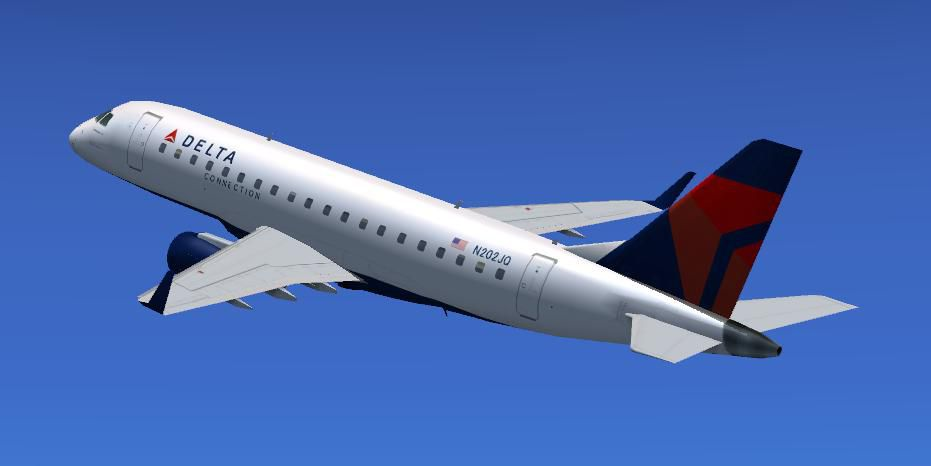

In [2]:
os.chdir("D:\\aircraft-audio\lax-naming-convention")
import IPython
from IPython.display import Image, Audio
print("Embraer")
Image(filename='embardier.png',width=300, height=200)

In [3]:
fs, audio_sample = wavfile.read("2019_07_21_17_02_29-LAX-E75L-skw5610-sba.wav")
IPython.display.Audio(audio_sample, rate=32000)

Airbus


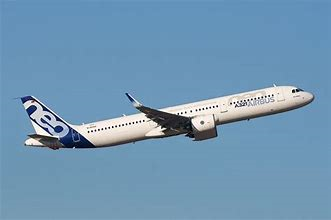

In [4]:
print("Airbus")
Image(filename='airbus.png',width=300, height=200)

### Load and Inspect Data

In [5]:
# Original audio recordings have already been split to samples of 1 second 32000 at sample rate and stored in numpy array.

os.chdir("D:\\aircraft-audio\\local-data")
print(os.getcwd())

Boeing_slices_train_matrix = np.loadtxt('Boeing_slices_train_matrix.txt', delimiter=',')
Boeing_slices_test_matrix = np.loadtxt('Boeing_slices_test_matrix.txt', delimiter=',')
Embraer_slices_train_matrix = np.loadtxt('Embraer_slices_train_matrix.txt', delimiter=',')
Embraer_slices_test_matrix = np.loadtxt('Embraer_slices_test_matrix.txt', delimiter=',')
Other_slices_train_matrix = np.loadtxt('Other_slices_train_matrix.txt', delimiter=',')
Other_slices_test_matrix = np.loadtxt('Other_slices_test_matrix.txt', delimiter=',')
       

D:\aircraft-audio\local-data


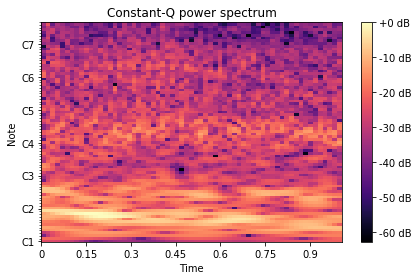

In [6]:
import librosa.display
import matplotlib.pyplot as plt
C = np.abs(librosa.cqt(Boeing_slices_train_matrix[20,:], sr=32000, fmin=librosa.note_to_hz('C1'), n_bins=80, bins_per_octave=12))
librosa.display.specshow(librosa.amplitude_to_db(C, ref=np.max),
                         sr=32000, x_axis='time', y_axis='cqt_note')
plt.colorbar(format='%+2.0f dB')
plt.title('Constant-Q power spectrum')
plt.tight_layout()

### Add Augmented Data

In [7]:
def _create_augmented_volume_reduction_data_matrix(old_matrix, volume_change):
    
    old_matrix = np.asarray(old_matrix)
    new_target_numpy = np.empty((32000),int)
    new_target_numpy = np.asarray(new_target_numpy)    

    for i in range(old_matrix.shape[0]):
        new_numpy = old_matrix[i,:] + volume_change
        new_numpy = np.asarray(new_numpy)
        new_target_numpy = np.vstack((new_target_numpy, new_numpy))
        new_target_numpy = np.asarray(new_target_numpy)
    return(new_target_numpy)

In [8]:
# Create Augmented matrices with volume reduction
Boeing_augmented_train_matrix= _create_augmented_volume_reduction_data_matrix(Boeing_slices_train_matrix, -5)
Embraer_augmented_train_matrix= _create_augmented_volume_reduction_data_matrix(Embraer_slices_train_matrix, -5)
Other_augmented_train_matrix= _create_augmented_volume_reduction_data_matrix(Other_slices_train_matrix, -5)

In [9]:
def _create_augmented_white_noise_data_matrix(old_matrix, noise_level):
    new_target_numpy = np.empty((32000),int)
    new_target_numpy = np.asarray(new_target_numpy)   
    
    for i in range(old_matrix.shape[0]):
        wn = np.random.randn(old_matrix.shape[1])
        new_numpy = old_matrix[i,:] + noise_level*wn
        new_numpy = np.asarray(new_numpy)
        new_target_numpy = np.vstack((new_target_numpy, new_numpy))
        new_target_numpy = np.asarray(new_target_numpy)
    return(new_target_numpy)
        

In [10]:
# Create Augmented matrices with white noise added
Embraer_augmented_train_matrix2= _create_augmented_white_noise_data_matrix(Embraer_slices_train_matrix,0.005)
Boeing_augmented_train_matrix2= _create_augmented_white_noise_data_matrix(Boeing_slices_train_matrix,0.005)
Other_augmented_train_matrix2= _create_augmented_white_noise_data_matrix(Other_slices_train_matrix,0.005)

### Add Labels

In [11]:
#Source Data Matrices

Boeing_slices_train_matrix = np.c_[ np.ones(len(Boeing_slices_train_matrix)),Boeing_slices_train_matrix] 
Boeing_slices_train_matrix[:, 0] =  0
print(Boeing_slices_train_matrix.shape)

Boeing_slices_test_matrix = np.c_[ np.ones(len(Boeing_slices_test_matrix)),Boeing_slices_test_matrix] 
Boeing_slices_test_matrix[:, 0] =  0
print(Boeing_slices_test_matrix.shape)

Embraer_slices_train_matrix = np.c_[ np.ones(len(Embraer_slices_train_matrix)),Embraer_slices_train_matrix] 
Embraer_slices_train_matrix[:, 0] = 1
print(Embraer_slices_train_matrix.shape)

Embraer_slices_test_matrix = np.c_[ np.ones(len(Embraer_slices_test_matrix)),Embraer_slices_test_matrix] 
Embraer_slices_test_matrix[:, 0] =  1
print(Embraer_slices_test_matrix.shape)

Other_slices_train_matrix = np.c_[ np.ones(len(Other_slices_train_matrix)),Other_slices_train_matrix] 
Other_slices_train_matrix[:, 0] = 0
print(Other_slices_train_matrix.shape)

Other_slices_test_matrix = np.c_[ np.ones(len(Other_slices_test_matrix)),Other_slices_test_matrix] 
Other_slices_test_matrix[:, 0] =  0
print(Other_slices_test_matrix.shape)

#Augmented Matrices

Boeing_augmented_train_matrix = np.c_[ np.ones(len(Boeing_augmented_train_matrix)),Boeing_augmented_train_matrix] 
Boeing_augmented_train_matrix[:, 0] = 0
Boeing_augmented_train_matrix = np.delete(Boeing_augmented_train_matrix, (0), axis=0)
print(Boeing_augmented_train_matrix.shape)

Embraer_augmented_train_matrix = np.c_[ np.ones(len(Embraer_augmented_train_matrix)),Embraer_augmented_train_matrix] 
Embraer_augmented_train_matrix[:, 0] = 1
Embraer_augmented_train_matrix = np.delete(Embraer_augmented_train_matrix, (0), axis=0)
print(Embraer_augmented_train_matrix.shape)


Embraer_augmented_train_matrix2 = np.c_[ np.ones(len(Embraer_augmented_train_matrix2)),Embraer_augmented_train_matrix2] 
Embraer_augmented_train_matrix2[:, 0] = 1
Embraer_augmented_train_matrix2 = np.delete(Embraer_augmented_train_matrix2, (0), axis=0)
print(Embraer_augmented_train_matrix2.shape)

Other_augmented_train_matrix = np.c_[ np.ones(len(Other_augmented_train_matrix)),Other_augmented_train_matrix] 
Other_augmented_train_matrix[:, 0] = 0
Other_augmented_train_matrix = np.delete(Other_augmented_train_matrix, (0), axis=0)
print(Other_augmented_train_matrix.shape)

Boeing_augmented_train_matrix2 = np.c_[ np.ones(len(Boeing_augmented_train_matrix2)),Boeing_augmented_train_matrix2] 
Boeing_augmented_train_matrix2[:, 0] = 0
Boeing_augmented_train_matrix2 = np.delete(Boeing_augmented_train_matrix2, (0), axis=0)
print(Boeing_augmented_train_matrix2.shape)

Other_augmented_train_matrix2 = np.c_[ np.ones(len(Other_augmented_train_matrix2)),Other_augmented_train_matrix2] 
Other_augmented_train_matrix2[:, 0] = 0
Other_augmented_train_matrix2 = np.delete(Other_augmented_train_matrix2, (0), axis=0)
print(Other_augmented_train_matrix2.shape)



(147, 32001)
(121, 32001)
(86, 32001)
(68, 32001)
(58, 32001)
(43, 32001)
(147, 32001)
(86, 32001)
(86, 32001)
(58, 32001)
(147, 32001)
(58, 32001)


### Split and Shuffle Data

In [12]:
all_train_data = np.append(Boeing_slices_train_matrix, Embraer_slices_train_matrix, axis=0)
all_train_data = np.append(all_train_data ,Other_slices_train_matrix, axis=0)

# Add augmented data just to training matrix
all_train_data = np.append(all_train_data ,Embraer_augmented_train_matrix, axis=0)
all_train_data = np.append(all_train_data ,Embraer_augmented_train_matrix2, axis=0)
all_train_data = np.append(all_train_data ,Boeing_augmented_train_matrix, axis=0)
all_train_data = np.append(all_train_data ,Boeing_augmented_train_matrix2, axis=0)
all_train_data = np.append(all_train_data ,Other_augmented_train_matrix, axis=0)
all_train_data = np.append(all_train_data ,Other_augmented_train_matrix2, axis=0)


all_test_data = np.append(Boeing_slices_test_matrix, Embraer_slices_test_matrix, axis=0)
all_test_data = np.append(all_test_data , Other_slices_test_matrix,axis=0)

np.random.shuffle(all_train_data)
np.random.shuffle(all_test_data)

y_train = np.asarray(all_train_data[:,0])
X_train = np.asarray(all_train_data[:,1:32001])

y_test = np.asarray(all_test_data[:,0])
X_test = np.asarray(all_test_data[:,1:32001])

In [13]:
print(y_train.shape)
print(X_train.shape)
print(y_test.shape)
print(X_test.shape)

(873,)
(873, 32000)
(232,)
(232, 32000)


### Save Intermediary Files

In [14]:
# np.savetxt('y_train.txt', y_train, delimiter=',')
# np.savetxt('X_train.txt', X_train, delimiter=',')
# np.savetxt('y_test.txt', y_test, delimiter=',')
# np.savetxt('X_test.txt', X_test, delimiter=',')

In [15]:
# y_train = np.loadtxt('y_train.txt', delimiter=',')
# X_train = np.loadtxt('X_train.txt', delimiter=',')
# y_test = np.loadtxt('y_test.txt', delimiter=',')
# X_test = np.loadtxt('X_test.txt', delimiter=',')       

In [16]:
y_train = np.asarray(y_train)
X_train = np.asarray(X_train)
y_test = np.asarray(y_test)
X_test = np.asarray(X_test)

In [17]:
X_test.shape

(232, 32000)

In [18]:
# Eliminate any rows that are all nulls
X_test_nulls = np.where(~X_test.any(axis=1))[0]
print(X_test_nulls)

X_train_nulls = np.where(~X_test.any(axis=1))[0]
X_train_nulls
# y = numpy.delete(x,(x), axis=1)
# print(y.shape)

[]


array([], dtype=int64)

### Slicing and Featurizing

In [ ]:
mfcc_data = []

In [ ]:
# Function to convert audio from integer to float range
def convert_audio_i2f(audio):
    audio = audio.astype(np.float32, order='C') / 32000.0
    return audio

In [ ]:
# Function to replace outliers
def replace_outliers(data_in, para=1.5):
    median = np.median(data_in)
    for val in range(0, len(data_in)):
        if (abs(data_in[val] - median)) >= (
                para * np.std(data_in)):  # std dev used of fund frequency for this class
            data_in[val] = median

    return data_in

In [ ]:
# Function to generate fundamental frequencies from audio sample
def fundamental_freq_gen(y):
    y = np.array(y).astype(np.float)
    sr = float(32000)
    # Predict fundamental frequency based on crepe pre-trained pitch model
    _, frequency, _, _ = crepe.predict(y,
                                       sr,
                                       viterbi=False,
                                       verbose=0, step_size=100,
                                       model_capacity="full")
    frequency = np.array(frequency)    
    # Reshape for one prediction
    frequency = frequency.reshape(1, -1)
    return frequency

In [ ]:
# Function to generate constant q and fundamental frequency features for each audio sample.
def _generate_features(data):
    allfreqs = []
    index = 0
    primary_input = []
    crepe_input = []
    labels = []
    data = np.asarray(data)
    data = data.astype(float)
    row_count = len(data)
    print(row_count)
    for x in range(0, row_count):
        raw_data = np.asarray(data[x,])
        crepe_data = np.asarray(data[x,])
        # stft_data = librosa.core.stft(convert_audio_i2f(raw_data))
        constant_q = np.abs(librosa.cqt(convert_audio_i2f(raw_data), sr=32000, fmin=librosa.note_to_hz('C1'), n_bins=70, bins_per_octave=12))
        constant_q_shape_1 = constant_q.shape[1]
        constant_q_shape_0 = constant_q.shape[0]
        primary_input.append(constant_q)
        
    primary_input = np.array(primary_input).reshape(-1, constant_q_shape_0, constant_q_shape_1, 1)
    print(primary_input.shape)

    for rows in range(0,row_count):
        freq = fundamental_freq_gen(data[rows,:])
        index = index + 1
        freq = np.array(freq)
        allfreqs.append(freq)
        crepe_input = np.array(allfreqs)

    print(crepe_input.shape)
    print(row_count)
    crepe_input= crepe_input.reshape(row_count, 11)
    normalized_crepe_input = np.array([replace_outliers(x) for x in crepe_input])
    print(normalized_crepe_input.shape)
    return primary_input, normalized_crepe_input

In [ ]:
# Generate Training Features
train_cq_input, train_crepe_input = _generate_features(X_train)

873
(873, 70, 63, 1)


C:\Anaconda\envs\amlrealtimeai\lib\site-packages\crepe\core.py:208: RuntimeWarning: invalid value encountered in true_divide
  frames /= np.std(frames, axis=1)[:, np.newaxis]
C:\Users\pattyry\AppData\Roaming\Python\Python36\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


(873, 1, 11)
873
(873, 11)


In [ ]:
# Generate test features
test_cq_input, crepe_test_input = _generate_features(X_test)

232
(232, 70, 63, 1)
(232, 1, 11)
232
(232, 11)


In [ ]:
#Define Single input shape
cq_input_shape = train_cq_input[0].shape
print("CQT Shape",cq_input_shape)
crepe_input_shape = train_crepe_input[0].shape
print("Crepe Input Shape", crepe_input_shape)

CQT Shape (70, 63, 1)
Crepe Input Shape (11,)


In [ ]:
# Convert labels to categorical
y_test_labels = to_categorical(y_test)
y_train_labels = to_categorical(y_train)

In [ ]:
#Check input sizes
print(train_cq_input.shape)
print(test_cq_input.shape)
print(train_crepe_input.shape)
print(crepe_test_input.shape)

(873, 70, 63, 1)
(232, 70, 63, 1)
(873, 11)
(232, 11)


### Model Building

#### Model Architecture

In [ ]:
def get_model():
    nclass = 2
    initializer1 = keras.initializers.RandomNormal
    initializer2 = keras.initializers.Zeros()
    initializer3 = keras.initializers.glorot_uniform(seed=None)
    initializer4 = keras.initializers.lecun_normal(seed=None)
    
    inp = Input(shape=cq_input_shape)
    img_1 = Conv2D(32, kernel_size=(3,3), activation='relu',         
                   kernel_initializer=initializer4,             
                   use_bias=True, bias_initializer=initializers.Zeros(),padding="valid")(inp)
    img_1 = Dropout(0.05)(img_1)
    img_1 = MaxPooling2D(pool_size=(2,2))(img_1)
    img_1 = Dropout(0.1)(img_1)
    img_1 = Flatten()(img_1)
    img_1 = Dense(14)(img_1)
    
    crepe_inp = Input(shape=crepe_input_shape)
    crepe_dense = Dense(32, activation='relu', kernel_initializer=initializer4,
                    bias_initializer=initializers.Zeros(),use_bias=True)(crepe_inp)
    crepe_dense = Dropout(0.1)(crepe_dense)   
    concat_layer = keras.layers.concatenate([img_1, crepe_dense])
    concat_dense = Dense(16, activation='relu', kernel_initializer=initializer4,
                         bias_initializer=initializers.Zeros(),use_bias=True)(concat_layer)
    concat_dense = Dropout(0.2)(concat_dense)
    concat_dense = Dense(12)(concat_dense)
    
    output_layer = Dense(2,activation=activations.sigmoid)(concat_dense)
    model = models.Model(inputs=[inp, crepe_inp], outputs=[output_layer])
    opt = optimizers.Adam(lr=0.000009, beta_1=0.9, beta_2=0.999, epsilon=1e-4, decay=0.0, amsgrad=True)
    model.compile(optimizer=opt, loss=losses.binary_crossentropy, metrics=['acc'])
    model.summary()
    return model

In [ ]:
# If wanted, add class weighting
total_len = len(y_train)
class_weight = {0: total_len/len([x for x in y_train==0 if x]),
                1: total_len/len([x for x in y_train==1 if x])}

In [ ]:
cq_crepe_model = get_model()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 70, 63, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 68, 61, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 68, 61, 32)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 34, 30, 32)   0           dropout_1[0][0]                  
__________________________________________________________________________________________________
dropout_2 

In [ ]:
mcp_save = ModelCheckpoint('best_airplane_landing_8_06.hdf5', save_best_only=True, monitor='val_acc', mode='max')


In [ ]:
# Check Shapes
print(train_cq_input.shape)
print(test_cq_input.shape)
print(train_crepe_input.shape)
print(crepe_test_input.shape)


(873, 70, 63, 1)
(232, 70, 63, 1)
(873, 11)
(232, 11)


In [ ]:
history = cq_crepe_model.fit([train_cq_input, train_crepe_input],[to_categorical(y_train)], 
                         epochs=1500, verbose=1, batch_size=12,
                         validation_data=([test_cq_input, crepe_test_input], to_categorical(y_test)), 
                         callbacks=[mcp_save], shuffle=True,
                         class_weight=class_weight, 
                         sample_weight=None)

Train on 873 samples, validate on 232 samples
Epoch 1/1500
873/873 [==============================] - 16s 19ms/step - loss: 14.4776 - acc: 0.3654 - val_loss: 9.4475 - val_acc: 0.3125
Epoch 2/1500
873/873 [==============================] - 12s 14ms/step - loss: 14.4313 - acc: 0.3757 - val_loss: 9.2428 - val_acc: 0.3147
Epoch 3/1500
873/873 [==============================] - 11s 13ms/step - loss: 14.3709 - acc: 0.3866 - val_loss: 9.1627 - val_acc: 0.3168
Epoch 4/1500
873/873 [==============================] - 12s 14ms/step - loss: 14.4278 - acc: 0.3923 - val_loss: 9.0465 - val_acc: 0.3297
Epoch 5/1500
873/873 [==============================] - 12s 14ms/step - loss: 14.1717 - acc: 0.3986 - val_loss: 8.8268 - val_acc: 0.3470
Epoch 6/1500
873/873 [==============================] - 12s 14ms/step - loss: 13.9553 - acc: 0.4181 - val_loss: 8.6917 - val_acc: 0.3491
Epoch 7/1500
873/873 [==============================] - 12s 14ms/step - loss: 13.7300 - acc: 0.4175 - val_loss: 8.7294 - val_acc: 0.

In [41]:
# stft_model.load_weights('best_stft_model_dropout_checkpoint.hdf5')

In [42]:
# Save Model
cq_crepe_model.save('_BEST_CQ_MODEL_DROPOUT.h5')

#### Graph the results

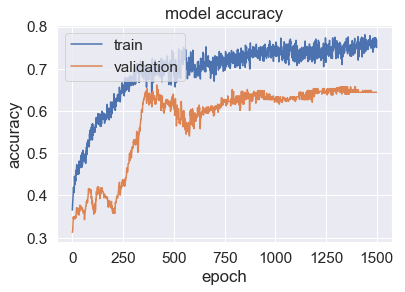

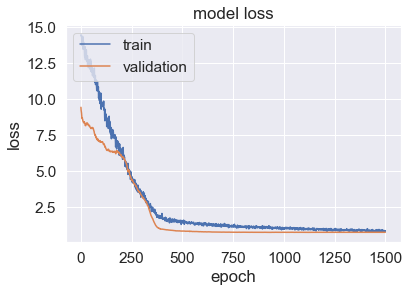

In [43]:
import matplotlib.pyplot as plt
#Accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [44]:
cq_crepe_model.evaluate([test_cq_input, crepe_test_input],y_test_labels)

232/232 [==============================] - 0s 634us/step


[0.7786599541532582, 0.6443965517241379]

#### Confusion Matrix

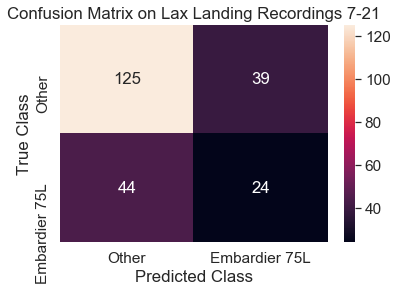

             precision    recall  f1-score   support

        0.0       0.74      0.76      0.75       164
        1.0       0.38      0.35      0.37        68

avg / total       0.63      0.64      0.64       232



In [45]:
preds =np.argmax(cq_crepe_model.predict([test_cq_input, crepe_test_input]), axis=1)
cm = confusion_matrix(y_test.tolist(), preds.tolist())

sns.set(font_scale=1.4)

ax = sns.heatmap(cm, annot=True, fmt='g')
ax.set_title('Confusion Matrix on Lax Landing Recordings 7-21')
ax.xaxis.set_ticklabels(['Other', 'Embardier 75L'])
ax.yaxis.set_ticklabels(['Other', 'Embardier 75L'])
ax.set(xlabel='Predicted Class', ylabel='True Class')
plt.show()
print(classification_report(y_test.tolist(), preds.tolist()))

In [ ]:
cm